In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1)
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

In [2]:
torch.cuda.is_available()

False

In [3]:
# Useing GPU device
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Data Preparation

In [4]:
im_size = 32 #Size of each image

# These values are mostly used by researchers as found to very useful in fast convergence
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]


# transformation
composed_train = transforms.Compose([transforms.Resize((im_size, im_size)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1, 
                                                            saturation = 0.1), 
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std)]) # Normalizing with standard mean and standard deviation


composed_test = transforms.Compose([transforms.Resize((im_size,im_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

### Load train and validation dataset

In [5]:
# Load the data and transform the dataset
train_dataset =  dsets.CIFAR10(root='C:/Users/Leila/Desktop/Python/datasets/data', train=True, download=True, transform = composed_train)
validation_dataset = dsets.CIFAR10(root='C:/Users/Leila/Desktop/Python/datasets/data', train=False, download=True, transform = composed_test)

# Create train and validation batch for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=150)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

Files already downloaded and verified
Files already downloaded and verified


Some important functions to print the images and image convertor from tensor to numpy

In [6]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('class = '+ str(img[1]))
    plt.show()
    
# Converting images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

Lets print some random datasets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


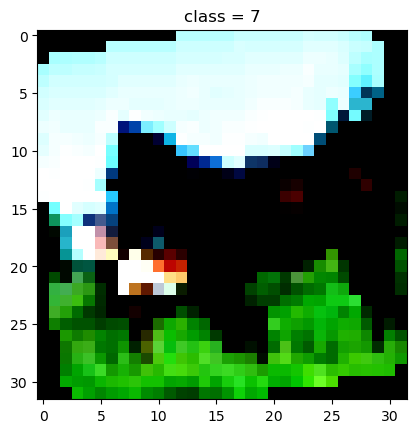

In [7]:
show_data(train_dataset[12]);

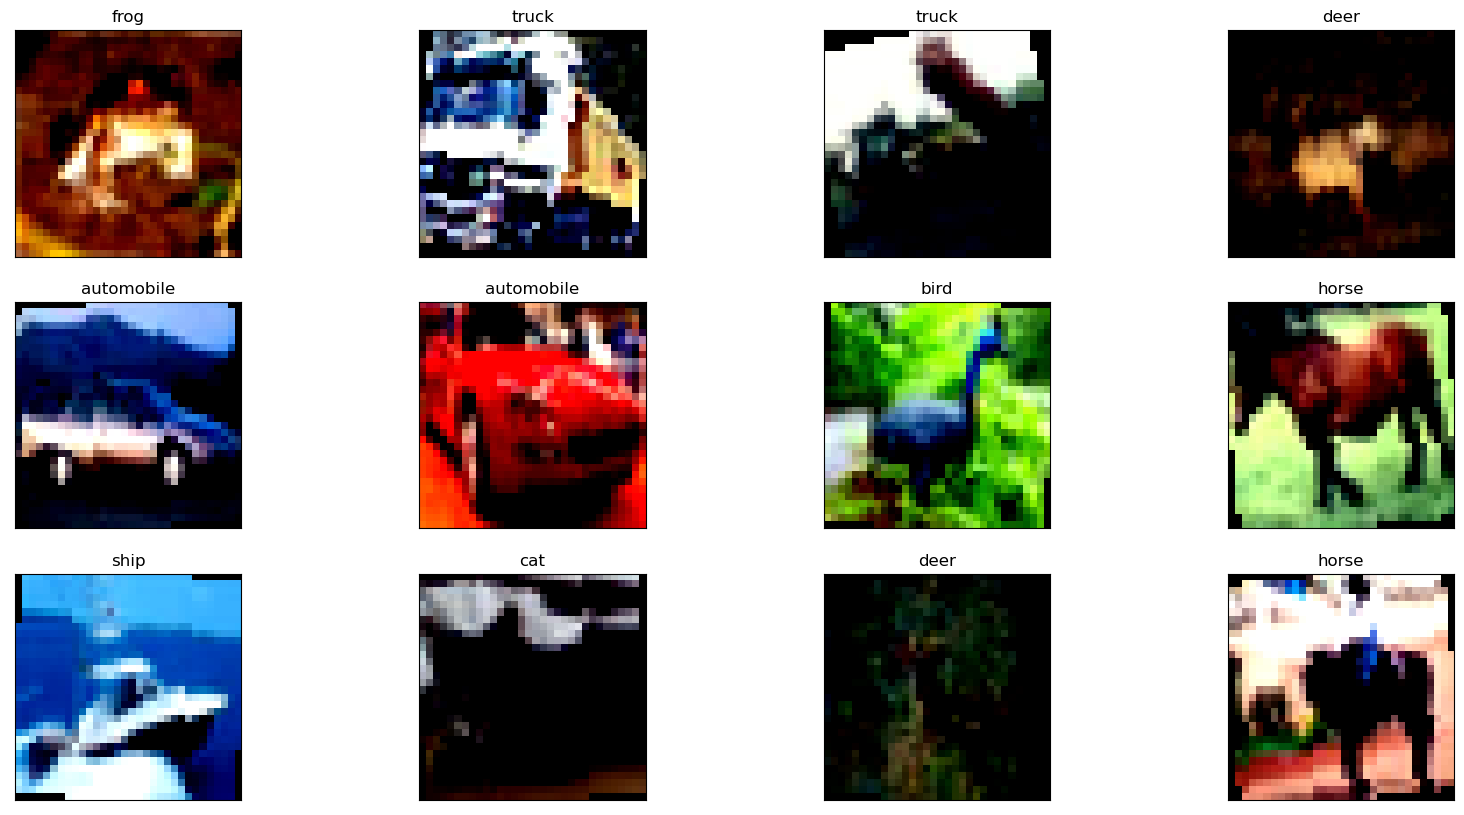

In [8]:
# There exist 10 different classes in CIPHAR-10 dataset
classes = ('airplane', 
           'automobile', 
           'bird',
           'cat',
           'deer',
           'dog', 
           'frog', 
           'horse', 
           'ship',
           'truck')

# Define an iterable on the data
data_iterable = iter(train_loader) # converting train_dataloader to iterable
images, labels = next(data_iterable) #moving from first batch of 100 images to the next batch
fig = plt.figure(figsize=(20, 10)) 

# Lets plot 50 images from the train_dataset
for indx in np.arange(12):
    ax = fig.add_subplot(3, 4, indx+1, xticks=[], yticks=[])
    
    # Note: imshow cant print tensor !
    # So convert tensor image to numpy by im_convert function 
    plt.imshow(im_convert(images[indx]))
    ax.set_title(classes[labels[indx].item()])

# 2. Convolution Neural Network

After trying several cases of Convolutional neural networks and fully connected layers, we apply the following method:

1. Three Convolution layers and four fully connected layers

2. We use momentum = 0.2 and dropout = 0.2 for convolutional layers and dropout = 0.5 for fully connected layers

In [9]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs = 10):
    
    # Global variable
    N_test = len(validation_dataset)
    accuracy_list = []
    train_loss_list = []
    model = model.to(device)
    train_cost_list = []
    val_cost_list = []
    
    for epoch in range(n_epochs):
        train_COST = 0
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            train_COST+=loss.item()
            
        train_COST = train_COST/len(train_loader)
        train_cost_list.append(train_COST)
        correct = 0
        
        # prediction on the validation data
        val_COST = 0
        for x_test, y_test in validation_loader:
            model.eval()
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            z = model(x_test)
            val_loss = criterion(z, y_test)
            _, y_hat = torch.max(z.data, 1)
            correct += (y_hat==y_test).sum().item()
            val_COST+=val_loss.item()
        
        val_COST = val_COST/ len(validation_loader)
        val_cost_list.append(val_COST)
            
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        
        print("--> Epoch Number : {}".format(epoch + 1),
              " | Training Loss : {}".format(round(train_COST,4)),
              " | Validation Loss : {}".format(round(val_COST,4)),
              " | Validation Accuracy : {}%".format(round(accuracy * 100, 2)))
        
    return accuracy_list, train_cost_list, val_cost_list

In [10]:
class CNN(nn.Module):
  
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.drop_conv = nn.Dropout(p=0.2)
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        
        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv3_bn = nn.BatchNorm2d(out_3)
        
        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000) 
        self.drop = nn.Dropout(p=0.5)
        self.fc1_bn = nn.BatchNorm1d(1000)
        
        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        self.fc2_bn = nn.BatchNorm1d(1000)

        # Hidden layer 3
        self.fc3 = nn.Linear(1000, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)
        
        # Hidden layer 4
        self.fc4 = nn.Linear(1000, 1000)
        self.fc4_bn = nn.BatchNorm1d(1000)
        
        # Final layer
        self.fc5 = nn.Linear(1000, 10)
        self.fc5_bn = nn.BatchNorm1d(10)
        
    # Predictiona
    def forward(self, x):
        
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.maxpool1(x)
        x = self.drop_conv(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.drop_conv(x)
        
        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.drop_conv(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = self.fc2_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc3(x)
        x = self.fc3_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc4(x)
        x = self.fc4_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc5(x)
        x = self.fc5_bn(x)
        
        return(x)

In [11]:
model = CNN(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normalv5, train_cost_listv5, val_cost_listv5=train_model(model=model, n_epochs=60, train_loader=train_loader, validation_loader=validation_loader, optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.7181  | Validation Loss : 1.472  | Validation Accuracy : 47.09%
--> Epoch Number : 2  | Training Loss : 1.4293  | Validation Loss : 1.2064  | Validation Accuracy : 56.38%
--> Epoch Number : 3  | Training Loss : 1.3047  | Validation Loss : 1.2701  | Validation Accuracy : 56.04%
--> Epoch Number : 4  | Training Loss : 1.2156  | Validation Loss : 1.032  | Validation Accuracy : 63.11%
--> Epoch Number : 5  | Training Loss : 1.142  | Validation Loss : 1.0678  | Validation Accuracy : 63.05%
--> Epoch Number : 6  | Training Loss : 1.0924  | Validation Loss : 0.9261  | Validation Accuracy : 67.57%
--> Epoch Number : 7  | Training Loss : 1.0428  | Validation Loss : 0.8984  | Validation Accuracy : 69.02%
--> Epoch Number : 8  | Training Loss : 1.0056  | Validation Loss : 0.899  | Validation Accuracy : 68.91%
--> Epoch Number : 9  | Training Loss : 0.97  | Validation Loss : 0.8102  | Validation Accuracy : 71.82%
--> Epoch Number : 10  | Training Loss : 0.

In [12]:
# Save the model
model = model.to(torch.device("cpu"))
pickle.dump(model, open('C:/Users/Leila/Desktop/Python/Machine-Learning/model_CNN.pkl', 'wb'))

# 3. Model Performance Report & Error Analysis

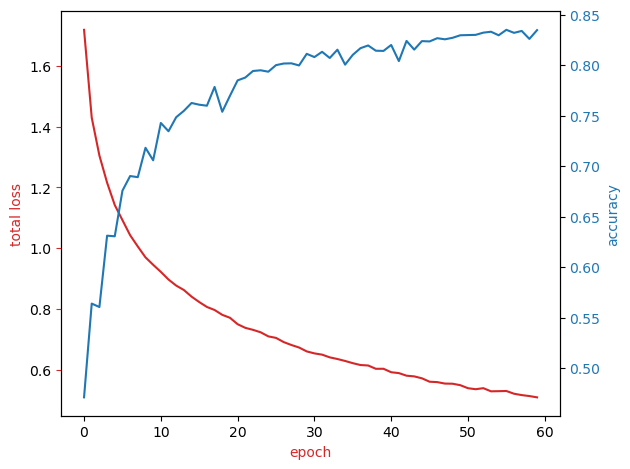

In [13]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(train_cost_listv5,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list_normalv5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

Printing training and validation loss:

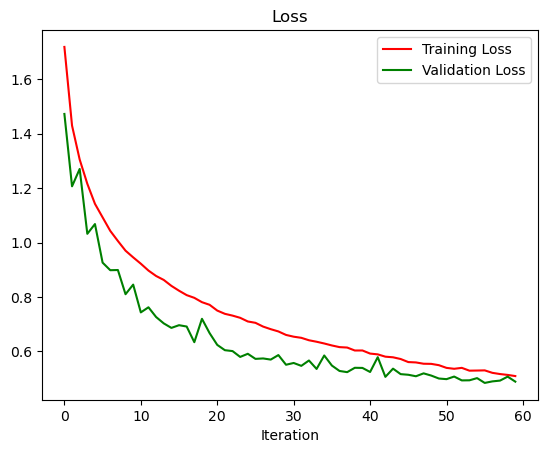

In [14]:
plt.plot(train_cost_listv5, 'r', label='Training Loss')
plt.plot(val_cost_listv5,  'g',  label='Validation Loss')
plt.xlabel("Iteration")
plt.title("Loss")
plt.legend()

## An important note:
    
We can see that the training loss and validation loss are close to each other. This gives a sense that we did a decent job in avoiding our model to overfit.

## Error Analysis: Printing Confusion Matrix & Classification Report :

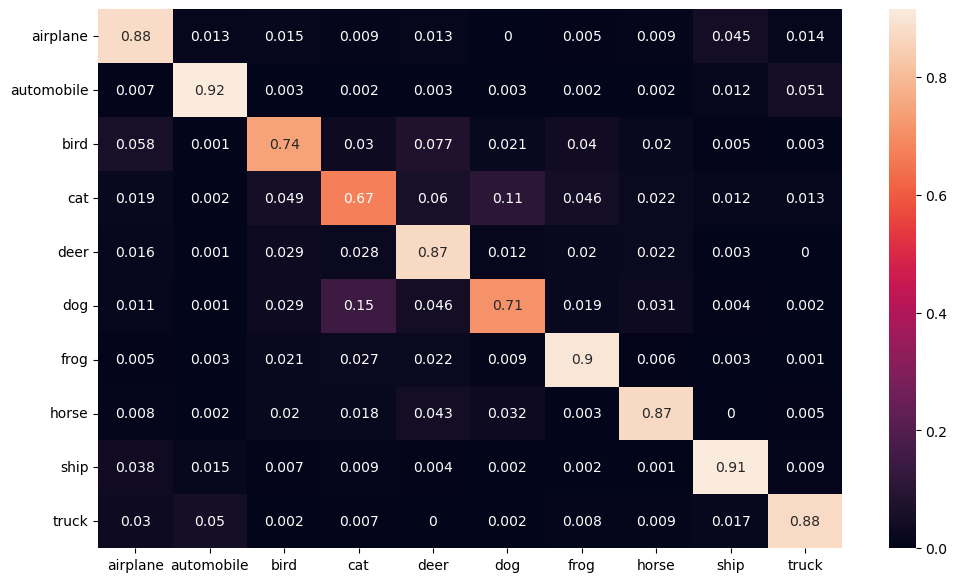

In [15]:
ypred = []
ytrue = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    
    #print('iter val', i)
    x = x.to(device)
    y = y.to(device)
    z = model(x)
    _, y_hat = torch.max(z, 1)
    pred = y_hat.data.cpu().numpy()
    ypred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    ytrue.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(ytrue, ypred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [16]:
print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1000
           1       0.91      0.92      0.91      1000
           2       0.81      0.74      0.78      1000
           3       0.71      0.67      0.69      1000
           4       0.76      0.87      0.81      1000
           5       0.79      0.71      0.75      1000
           6       0.86      0.90      0.88      1000
           7       0.88      0.87      0.87      1000
           8       0.90      0.91      0.91      1000
           9       0.90      0.88      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



## Plot some missclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


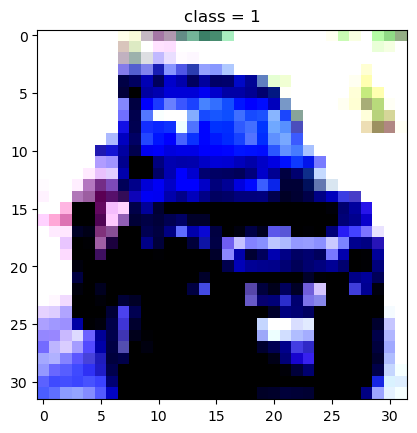

y_hat:  tensor([9])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


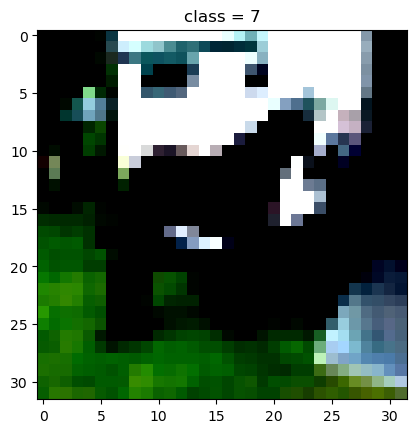

y_hat:  tensor([9])
Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


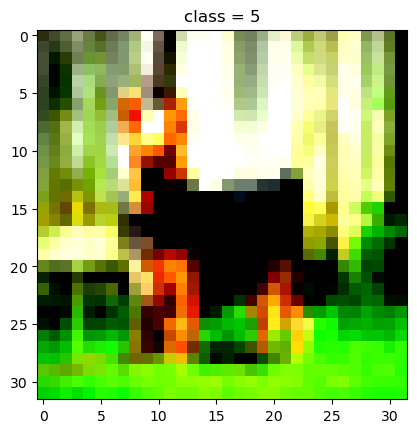

y_hat:  tensor([4])


In [17]:
count = 0
i = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    #print('iter val', i)
    x = x.to(device)
    y = y.to(device)
    z = model(x)
    _, y_hat = torch.max(z, 1)
    if y_hat != y:
        show_data(validation_dataset[i])
        plt.show()
        print("y_hat: ", y_hat)
        count += 1
    if count >= 3:
        break
    i+=1

## Printing how out model performs on the first 30 images:

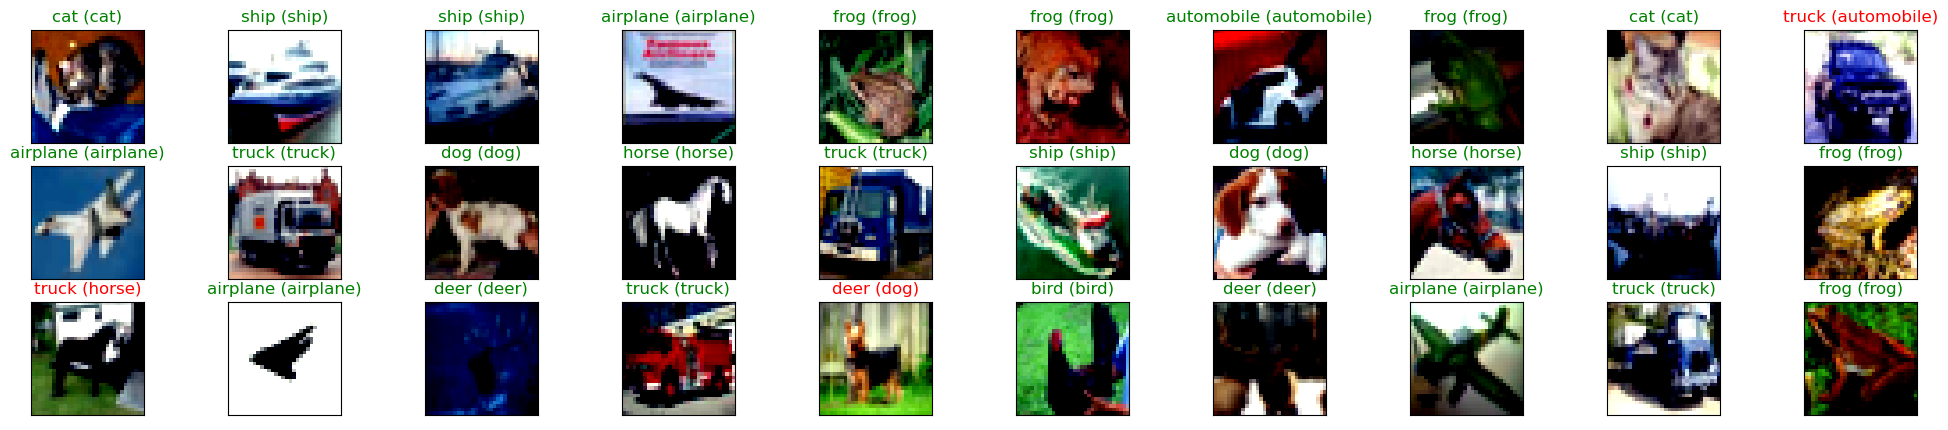

In [18]:
data_iterable = iter(validation_loader)
images, labels = next(data_iterable)
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 5))

for indx in np.arange(30):
    ax = fig.add_subplot(3, 10, indx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[indx]))
    ax.set_title("{} ({})".format(str(classes[preds[indx].item()]), str(classes[labels[indx].item()])), color=("green" if preds[indx]==labels[indx] else "red"))

# 4. Predict Test Set

In [19]:
class TestImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, indx):
        # Define the path where images are stored by yourself.
        # Remember, the first image is ./train/1.png
        img_path = self.img_dir + '/' + str(self.img_labels.iloc[indx, 0]) +'.png'

        # Read image. Recall how you converted an image to numpy array in the previous step.
        image = np.asarray(Image.open(img_path).convert('RGB'))

        label = self.img_labels.iloc[indx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [22]:
#Creating transform pipeline for test data
composed_test_check = transforms.Compose([transforms.ToPILImage(), 
                                          transforms.Resize((im_size, im_size)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean, std)])

SUBMISSION = os.path.join(os.getcwd(),"C:/Users/Leila/Desktop/Python/datasets/data/sampleSubmission.csv")
test_dataset = TestImageDataset(annotations_file=SUBMISSION, img_dir='C:/Users/Leila/Desktop/Python/datasets/data/test', transform=composed_test_check)
test_loader = DataLoader(dataset=test_dataset, batch_size=500, shuffle=False)

# Load the submission file
submit_df = pd.read_csv(SUBMISSION)

# Define an encoder
label_encoder = preprocessing.LabelEncoder()   
# Fit the encoder
label_encoder.fit_transform(list(classes))

# Iteratively predict the target and update the submission file
model = model.to(device)
i = 0
y_test_pred_list = []
for X_test, _ in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000):

    X_test = X_test.to(device) # Move X_train to the GPU
    model.eval()

    _, y_test_pred = torch.max(model(X_test), 1) # Pick the most probable label

    # Move the predicted values to CPU.
    y_test_pred = y_test_pred.cpu()   

    # As submission expects actual category names such as cat, the predicted values have to be transformed. 
    y_test_pred = label_encoder.inverse_transform(y_test_pred)
    y_test_pred_list.extend(y_test_pred)
    
# Add labels to submission file
submit_df['label'] = y_test_pred_list

In [ ]:
# Save result on test data 
submit_df.to_csv('test_result.csv', index = False)